This script creates a phantom where each voxel in the volume has a unique set of IVIM parameters (f, D*, D). These are then fitted with different models, and the bias of each model is plotted as a heat map.

Begin by specifying the number of voxels in each dimension, and the b-values to be used.

In [40]:
import numpy as np
n = 10 # Number of voxels in each dimension
factor = 1000
b_values = np.array([0, 50, 240, 800])/factor# The b-values for the signal calculation
b_values = np.array([0, 0.05, 0.240, 0.800])


Create the phantom and simulate the IVIM-signal for each b-value.

In [41]:
import numpy as np
from tqdm import tqdm

def ivim_signal(b, f, D_star, D, S0=1):
    return S0*(f*np.exp(-b*D_star) + (1-f)*np.exp(-b*D))

# Creates the gradients
f_gradient = np.linspace(0.02, 0.5, n)
D_star_gradient = np.linspace(0.005*factor, 0.03*factor, n)
D_gradient = np.linspace(5e-5*factor, 0.003*factor, n)

f_gradient = np.linspace(0.02, 0.5, n)
D_star_gradient = np.linspace(5, 30, n)
D_gradient = np.linspace(5e-2, 3, n)

# Create the phantom volume, with each voxel having a unique set of parameter values
f, D_star, D = np.meshgrid(f_gradient, D_star_gradient, D_gradient)

# Calculate the IVIM-signal for each voxel
signal = np.zeros((n, n, n, len(b_values)))
for f_index in tqdm(range(n)):
    for D_star_index in range(n):
        for D_index in range(n):
            for b_value_index in range(len(b_values)):
                signal[f_index, D_star_index, D_index, b_value_index] = ivim_signal(b_values[b_value_index],
                                                                                    f[f_index, D_star_index, D_index],
                                                                                    D_star[f_index, D_star_index, D_index],
                                                                                    D[f_index, D_star_index, D_index])

100%|██████████| 10/10 [00:00<00:00, 223.21it/s]


Let's define some functions that fits the data.

In [34]:
from dipy.reconst.ivim import IvimModel
from dipy.core.gradients import gradient_table
import topopro # File from Fadnavis Github https://github.com/ShreyasFadnavis/topopro
from scipy.optimize import curve_fit
import math
import topopro_test

def fit_VarPro(signal_volume, bvals=b_values*factor, bounds_lower=[0,0,0]):
    # Gradient table
    bvec = np.zeros((bvals.size, 3))
    bvec[:,2] = 1
    gtab = gradient_table(bvals, bvec, b0_threshold=0)
    
    # Create model
    bounds_lower = [0, 0, 0]
    bounds_upper = [1, 0.1, 0.004]
    ivimmodel = IvimModel(gtab, fit_method="VarPro", bounds=(bounds_lower, bounds_upper))
    
    ivimfit = ivimmodel.fit(signal_volume)
    
    S0_fit = ivimfit.model_params[:,:,:,0]
    f_fit = ivimfit.model_params[:,:,:,1]
    D_star_fit = ivimfit.model_params[:,:,:,2]*factor
    D_fit = ivimfit.model_params[:,:,:,3]*factor
    
    return S0_fit, f_fit, D_star_fit, D_fit

def fit_TopoPro(signal_volume, bvals=b_values*factor):
    # Gradient table
    bvec = np.zeros((bvals.size, 3))
    bvec[:,2] = 1
    gtab = gradient_table(bvals, bvec, b0_threshold=0)
    
    # Create model
    ivimmodel = topopro.IvimModelTopoPro(gtab)
    
    ivimfit = ivimmodel.fit(signal_volume)
    
    S0_fit = ivimfit.model_params[:,:,:,0]
    f_fit = ivimfit.model_params[:,:,:,1]
    D_star_fit = ivimfit.model_params[:,:,:,2]*factor
    D_fit = ivimfit.model_params[:,:,:,3]*factor
    
    return S0_fit, f_fit, D_star_fit, D_fit


def fit_TopoPro_test(signal_volume, bvals=b_values, iters=5):
    # Gradient table
    bvec = np.zeros((bvals.size, 3))
    bvec[:,2] = 1
    gtab = gradient_table(bvals, bvec, b0_threshold=0)
    
    # Create model
    ivimmodel = topopro_test.IvimModelTopoPro(gtab, iters=iters)
    
    ivimfit = ivimmodel.fit(signal_volume)
    
    S0_fit = ivimfit.model_params[:,:,:,0]
    f_fit = ivimfit.model_params[:,:,:,1]
    D_star_fit = ivimfit.model_params[:,:,:,2]
    D_fit = ivimfit.model_params[:,:,:,3]
    
    return S0_fit, f_fit, D_star_fit, D_fit

def fit_linear(signal_volume, bvals=b_values, b_threshold=200/factor):
    # Create the result images
    f = np.empty(signal_volume.shape[0:-1])
    D = np.empty(signal_volume.shape[0:-1])
    S0 = np.empty(signal_volume.shape[0:-1])

    # Function for S0
    def s0_voxel_value(s_b0, f):
        s0 = s_b0/(1-f)
        s0 = np.nan_to_num(s0)
        return s0

    # The model to be fit
    def func(b, adc, intercept):
        res = -b*adc + intercept
        return res
    
    bval_index_start = np.where(bvals >= b_threshold)[0][0]
    xdata = [b for b in bvals if b >= b_threshold]

    for row in tqdm(range(signal_volume.shape[0])):
        for col in range(signal_volume.shape[1]):
            for slice in range(signal_volume.shape[2]):
                # Fit the data to the function
                ydata = np.log(signal_volume[row, col, slice, bval_index_start:]/signal_volume[row, col, slice, 0])
                ydata = np.nan_to_num(ydata)
                res = curve_fit(func, xdata, ydata, bounds=([0, -1], [4,0]))[0]
                
                # Assign the fitted parameters to their voxels in the parameter maps
                f[row, col, slice] = -res[1]
                D[row, col, slice] = res[0]
                
                # Calculate S0
                S0[row, col, slice] = s0_voxel_value(signal_volume[row, col, slice, 0], res[1])
                
    return S0, f, D

def fit_segmented(signal_volume, bvals=b_values, b_threshold=200/factor):
    """
    The segmented method as described by Denis Le Bihan.

    Args:
        signal_volume (4D array [row, col, slice, b]): The signal data points to be fitted to.
        bvals (array, optional): b-values corresponding to the data points, in ms/µm2. Defaults to b_values.
        b_threshold (int, optional): The threshold b-value for the fit of D in ms/µm2. Defaults to 200/factor.

    Returns:
        S0, f, D_star, D: Arrays for the parameter estimates.
    """
    
    # Create result images
    f = np.empty(signal_volume.shape[0:-1])
    D = np.empty(signal_volume.shape[0:-1])
    D_star = np.empty(signal_volume.shape[0:-1])
    S0 = np.empty(signal_volume.shape[0:-1])
    
    def diffusion_signal(b, S0, D):
        return S0*np.exp(-b*D)
    
    def perfusion_signal(b, S0, D_star):
        return S0*np.exp(-b*D_star)
    
    b_threshold_index = np.where(bvals >= b_threshold)[0][0]
    xdata = [b for b in bvals if b >= b_threshold]
    
    for row in tqdm(range(signal_volume.shape[0])):
        for col in range(signal_volume.shape[1]):
            for slice in range(signal_volume.shape[2]):
                # Fit the diffusion signal to bvals >= b_threshold
                ydata = signal_volume[row, col, slice, b_threshold_index:]
                S0_diff_est, D_est = curve_fit(diffusion_signal, xdata, ydata, bounds=((0, 0), (np.inf, 4)))[0]
                
                # Assign the D estimate to the result
                D[row, col, slice] = D_est
                
                # Subtract the diffusion signal from the total IVIM signal
                diff_est = np.array([diffusion_signal(b, S0_diff_est, D_est) for b in bvals])
                #perfusion_ydata = [signal_volume[row, col, slice, :] - diff_est[i] for i in range(len(ydata))]
                perfusion_ydata = signal_volume[row, col, slice, :] - diff_est
                
                # Fit the perfusion signal to the new ydata
                S0_perf_est, D_star_est = curve_fit(perfusion_signal, bvals, perfusion_ydata, bounds=((0,5), (np.inf, 100)))[0]
                
                # Calculate f and S0
                S0_est = S0_diff_est+S0_perf_est
                f_est = S0_perf_est/S0_est
                
                # Assign the estimates to the results
                S0[row, col, slice] = S0_est
                f[row, col, slice] = f_est
                D_star[row, col, slice] = D_star_est
    
    return S0, f, D_star, D

def fit_TRR(signal_volume, bvals=b_values, b_threshold_lower=50/factor, b_threshold_upper=240/factor):
    
    def diffusion_signal(b, S0, D):
        return S0*np.exp(-b*D)
    
    def perfusion_signal(b, S0, D_star):
        return S0*np.exp(-b*D_star)
    
    def ivim_signal(b, S0, f, D_star, D):
        return S0*(f*np.exp(-b*D_star) + (1-f)*np.exp(-b*D))
    
    # Create the result arrays
    f = np.empty(signal_volume.shape[0:-1])
    D = np.empty(signal_volume.shape[0:-1])
    D_star = np.empty(signal_volume.shape[0:-1])
    S0 = np.empty(signal_volume.shape[0:-1])
    
    b_threshold_lower_idx = np.where(bvals <= b_threshold_lower)[0][0]
    b_threshold_upper_idx = np.where(bvals >= b_threshold_upper)[0][0]
    xdata_lower = [b for b in bvals if b <= b_threshold_lower]
    xdata_upper = [b for b in bvals if b >= b_threshold_upper]
    
    for row in tqdm(range(signal_volume.shape[0])):
        for col in range(signal_volume.shape[1]):
            for slice in range(signal_volume.shape[2]):
                # Fit the diffusion signal to bvals >= bval_threshold_upper
                ydata_upper = signal_volume[row, col, slice, b_threshold_upper_idx:]
                S0_diff_est, D_est = curve_fit(diffusion_signal, xdata_upper, ydata_upper, bounds=((0, 0), (np.inf, 4)))[0]
                
                # Assign D_est to the results
                D[row, col, slice] = D_est
                
                # Fit the diffusion signal to bvals <= bval_threshold_lower
                ydata_lower = signal_volume[row, col, slice, :b_threshold_lower_idx+1]
                S0_perf_est, D_star_est = curve_fit(diffusion_signal, xdata_lower, ydata_lower, bounds=((0,0), (np.inf, 100)))[0]
                
                # Estimate f
                f_guess = 1 - S0_diff_est/S0_perf_est
                
                # Perform fit to full model with fixed D, using f_guess as an initial guess for f
                S0_est, f_est, D_star_est = curve_fit(lambda b, S0, f, D_star: ivim_signal(b, S0, f, D_star, D_est), bvals, signal_volume[row, col, slice, :], bounds=((0, 0, 5), (np.inf, 1, 100)), p0=[900, f_guess, 10])[0]
                
                # Assign the estimates to their respective arrays
                S0[row, col, slice] = S0_est
                f[row, col, slice] = f_est
                D_star[row, col, slice] = D_star_est
    
    return S0, f, D_star, D

from scipy.signal import unit_impulse
def fit_sIVIM(signal_volume, bvals=b_values, b_threshold=200/factor):
    
    def ivim_signal(b, S0, f, D):
        """
        if b == 0:
            res = S0*(f + (1-f)*np.exp(-b*D))
        else:
            res = S0*(1-f)*np.exp(-b*D)
        return res
        """
        delta = unit_impulse(b.shape, idx=0)
        res = S0*(f*delta + (1-f)*np.exp(-b*D))
        return res
    
    # Create the result arrays
    S0 = np.zeros(signal_volume.shape[:-1])
    f = np.zeros(signal_volume.shape[:-1])
    D = np.zeros(signal_volume.shape[:-1])
    
    b_threshold_idx = np.where(bvals >= b_threshold)[0][0]
    xdata = bvals[b_threshold_idx:]
    xdata = np.insert(xdata, 0, 0) # Inserts b-value 0 at index 0
    
    # Cut away the b-values between 0 and b_threshold from the signal volume
    signal_indices = [0] + list(range(b_threshold_idx, signal_volume.shape[3]))
    signal_volume = signal_volume[:,:,:,signal_indices]
    
    for row in tqdm(range(signal_volume.shape[0])):
        for col in range(signal_volume.shape[1]):
            for slice in range(signal_volume.shape[2]):
                ydata = signal_volume[row, col, slice, :]
                S0_est, f_est, D_est = curve_fit(ivim_signal, xdata, ydata, bounds=((0,0,0), (np.inf, 1, 5)))[0]
                
                S0[row, col, slice] = S0_est
                f[row, col, slice] = f_est
                D[row, col, slice] = D_est
                
    return S0, f, D
                
                
    
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib notebook

def bias_plot(param_map, ground_truth, D_slice, fit_method="", ticks=None, parameter=""):
    
    fig, axs = plt.subplots(ncols=3, figsize=(11,3))
    
    cbar0 = axs[0].pcolormesh(f_gradient, D_star_gradient, ground_truth[:,:,D_slice], cmap="gray")
    axs[0].set_xlabel("f", fontsize="large")
    axs[0].set_ylabel("D* [µm$^2$/ms]", fontsize="large")
    axs[0].set_title("{} ground truth, D = {} µm$^2$/ms".format(fit_method, round(D_gradient[D_slice],5)))
    
    cbar1 = axs[1].pcolormesh(f_gradient, D_star_gradient, param_map[:,:,D_slice], cmap="gray")
    axs[1].set_xlabel("f", fontsize="large")
    axs[1].set_ylabel("D* [µm$^2$/ms]", fontsize="large")
    axs[1].set_title("{} fit, D = {} µm$^2$/ms".format(fit_method, round(D_gradient[D_slice],5)))
    
    bias = param_map[:,:,D_slice] - ground_truth[:,:,D_slice]
    bias_min = [-1e-10, np.min(bias)]    
    if ticks == None:
        if np.max(bias) < 0:
            divnorm=colors.TwoSlopeNorm(vmin=np.min(bias_min), vcenter=np.max(bias), vmax=0)
        else: 
            divnorm=colors.TwoSlopeNorm(vmin=np.min(bias_min), vcenter=0, vmax=np.max(bias))
    else:
        divnorm=colors.TwoSlopeNorm(vmin=np.min(np.array(ticks)), vcenter=0., vmax=np.max(np.array(ticks)))
    
    cbar2 = axs[2].pcolormesh(f_gradient, D_star_gradient, bias, cmap="bwr", norm=divnorm)
    axs[2].set_xlabel("f", fontsize="large")
    axs[2].set_ylabel("D* [µm$^2$/ms]", fontsize="large")
    axs[2].set_title("{} bias, D = {} µm$^2$/ms".format(fit_method, round(D_gradient[D_slice],5)))
                    
   
    
    
    fig.colorbar(cbar0, ax=axs[0], label="{} value".format(parameter))
    fig.colorbar(cbar1, ax=axs[1], label="{} value".format(parameter))
    if ticks == None:
        fig.colorbar(cbar2, ax=axs[2], label="Bias")
    else:
        fig.colorbar(cbar2, ax=axs[2], ticks=ticks, label="Bias")
    fig.tight_layout()
    
import warnings
warnings.filterwarnings("ignore") # stänger av varningar, ngt konstigt i nästa cell

### Fit the data
With TopoPro, DiPy VarPro, and linear fit

In [35]:
S0_fit_topopro5, f_fit_topopro5, D_star_fit_topopro5, D_fit_topopro5 = fit_TopoPro_test(signal, iters=5)
#S0_fit_topopro2, f_fit_topopro2, D_star_fit_topopro2, D_fit_topopro2 = fit_TopoPro_test(signal, iters=2)
#S0_fit_varpro, f_fit_varpro, D_star_fit_varpro, D_fit_varpro = fit_VarPro(signal)
#S0_fit_varpro2, f_fit_varpro2, D_star_fit_varpro2, D_fit_varpro2 = fit_VarPro(signal, bounds_lower=[0,0.005, 0])
S0_fit_linear, f_fit_linear, D_fit_linear = fit_linear(signal)

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


In [22]:
S0_fit_sIVIM, f_fit_sIVIM, D_fit_sIVIM = fit_sIVIM(signal)
S0_fit_segmented, f_fit_segmented, D_star_fit_segmented, D_fit_segmented = fit_segmented(signal)
S0_fit_TRR, f_fit_TRR, D_star_fit_TRR, D_fit_TRR = fit_TRR(signal)

100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


### Bias maps for f

D is in the slice-direction of the signal volume. Let's plot the bias for a typical value of D

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


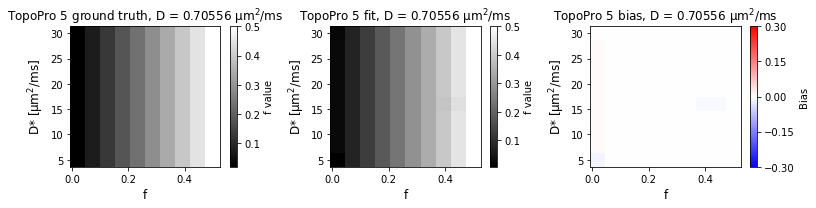

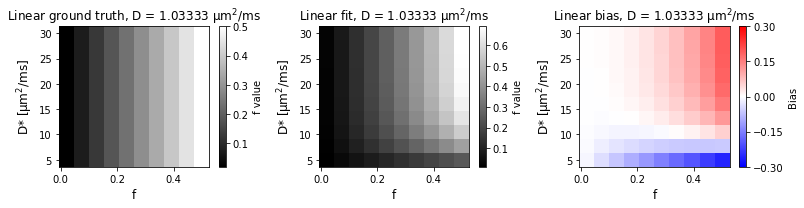

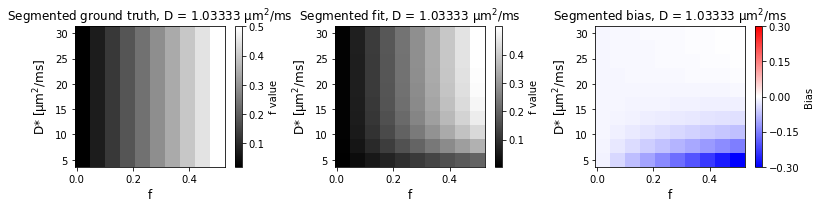

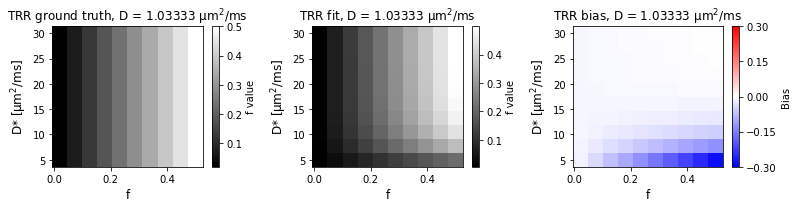

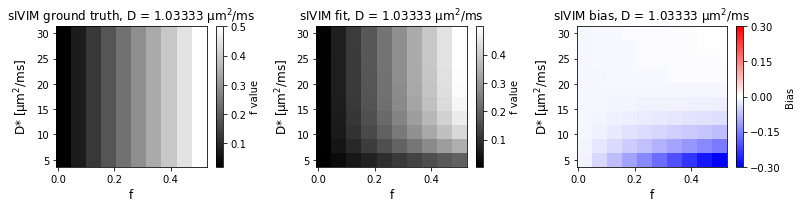

In [38]:
%matplotlib inline
ticks = [-.3, -.15, 0, .15, .3]
#bias_plot(f_fit_topopro2, f, 7, fit_method="TopoPro 2", parameter="f", ticks=ticks)
bias_plot(f_fit_topopro5, f, 2, fit_method="TopoPro 5", parameter="f", ticks=ticks)
#bias_plot(f_fit_varpro, f, 7, fit_method="VarPro", parameter="f", ticks=ticks)
#bias_plot(f_fit_varpro2, f, 7, fit_method="VarPro 2", parameter="f", ticks=ticks)
bias_plot(f_fit_linear, f, 3, fit_method="Linear", parameter="f", ticks=ticks)
bias_plot(f_fit_segmented, f, 3, fit_method="Segmented", parameter="f", ticks=ticks)
bias_plot(f_fit_TRR, f, 3, fit_method="TRR", parameter="f", ticks=ticks)
bias_plot(f_fit_sIVIM, f, 3, fit_method="sIVIM", parameter="f", ticks=ticks)

### Bias maps for D*

  4%|▍         | 38/1000 [1:15:03<31:39:58, 118.50s/it]


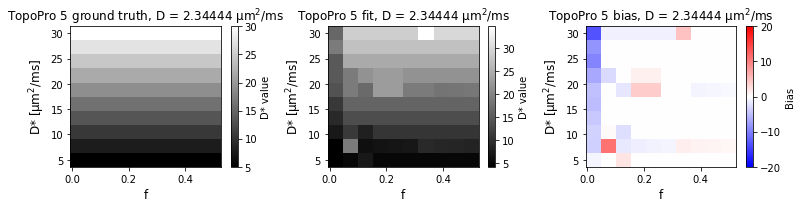

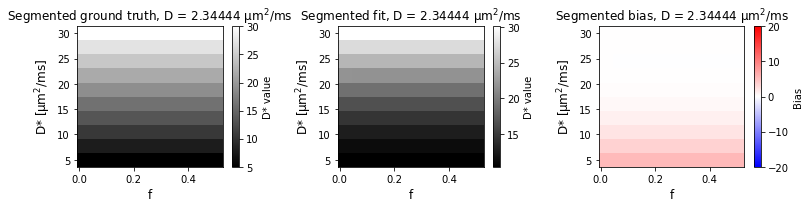

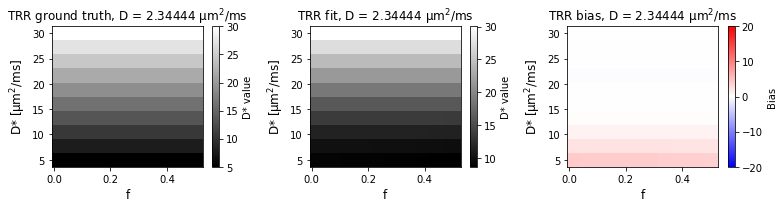

In [42]:
#bias_plot(D_star_fit_topopro2, D_star, 7, fit_method="TopoPro 2", parameter="D*", ticks=[-20, -10, 0, 10, 20])
bias_plot(D_star_fit_topopro5, D_star, 7, fit_method="TopoPro 5", parameter="D*", ticks=[-20, -10, 0, 10, 20])
#bias_plot(D_star_fit_varpro, D_star, 7, fit_method="VarPro", parameter="D*", ticks=[-20, -10, 0, 10, 20])
bias_plot(D_star_fit_segmented, D_star, 7, fit_method="Segmented", parameter="D*", ticks=[-20, -10, 0, 10, 20])
bias_plot(D_star_fit_TRR, D_star, 7, fit_method="TRR", parameter="D*", ticks=[-20, -10, 0, 10, 20])

### Bias maps for D

posx and posy should be finite values
posx and posy should be finite values


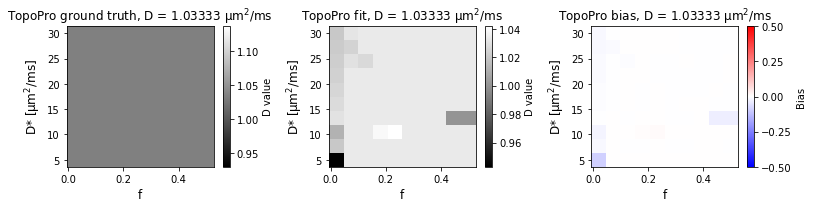

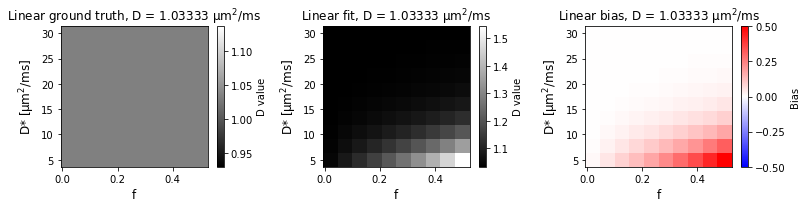

In [45]:
bias_plot(D_fit_topopro5, D, 3, fit_method="TopoPro", parameter="D", ticks=[-0.5, -.25, 0, .25, 0.5])
#bias_plot(D_fit_varpro, D, 7, fit_method="VarPro", parameter="D", ticks=[-0.5, -.25, 0, .25, .5])
bias_plot(D_fit_linear, D, 3, fit_method="Linear", parameter="D", ticks=[-0.5, -.25, 0, .25, .5])